In [60]:
import numpy as np
from scipy import signal
from scipy.signal import stft
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from copy import deepcopy
from math import prod

In [61]:
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    """Filtro passa-banda Butterworth"""
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    """Filtro notch Butterworth para remover ruído de 60Hz"""
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

In [62]:
def PSD(w):
    """Densidade espectral de potência"""
    return np.abs(w) ** 2

def var(x):
    """Variância do sinal"""
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    """Root Mean Square"""
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape)))

def wl(x):
    """Waveform Length"""
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def zc(x):
    """Zero Crossing"""
    signs = np.sign(x)
    return np.sum(np.abs(np.diff(signs, axis=-1)) > 0, axis=-1)

def fmd(w):
    """Median Frequency"""
    return np.sum(PSD(w), axis=-1) / 2

def fmn(w, fs=200):
    """Mean Frequency"""
    freqs = np.linspace(0, fs/2, w.shape[-1])
    return np.sum(freqs * PSD(w), axis=-1) / np.sum(PSD(w), axis=-1)

def mmdf(w):
    """Modified Median Frequency"""
    return np.sum(np.abs(w), axis=-1) / 2

def mmnf(w, fs=200):
    """Modified Mean Frequency"""
    freqs = np.linspace(0, fs/2, w.shape[-1])
    return np.sum(freqs * np.abs(w), axis=-1) / np.sum(np.abs(w), axis=-1)


In [63]:
trials = [f"dataset/s10_{i}.npy" for i in range(1, 4)]
all_data = [np.load(trial) for trial in trials]

for i, data in enumerate(all_data, start=1):
    print(f"Trial s10_{i}.npy shape: {data.shape}")

full_data = np.concatenate(all_data, axis=2)
full_data = full_data.transpose(0, 2, 1)

data_filtered = butter_notch(full_data.transpose(0, 2, 1), 60)
data_filtered = butter_bandpass(data_filtered, 5., 50.)
data_filtered = data_filtered.transpose(0, 2, 1)
data_filtered.shape

Trial s10_1.npy shape: (8, 1600, 4)
Trial s10_2.npy shape: (8, 1600, 4)
Trial s10_3.npy shape: (8, 1600, 4)


(8, 12, 1600)

In [ ]:
step = 100
segment = 256
n_samples = data_filtered.shape[2]
n_win = (n_samples - segment) // step + 1

chunks_time = np.array([data_filtered[:, :, k:(k + segment)] for k in np.arange(n_win) * step])
chunks_time = chunks_time.transpose(1, 0, 2, 3)

_, _, chunks_freq = stft(data_filtered, 
                        fs=200,
                        nperseg=segment,
                        noverlap=segment-step,
                        axis=-1)
chunks_freq = np.abs(chunks_freq)[:, :, :n_win, :]
chunks_freq = chunks_freq.transpose(0, 2, 1, 3)

print("Shapes consistentes:")
print(f"Temporal: {chunks_time.shape}")
print(f"Frequência: {chunks_freq.shape}")

Shapes consistentes:
Temporal: (8, 14, 12, 256)
Frequência: (8, 14, 12, 17)


In [65]:
features_list = []

features_list.append(var(chunks_time))
features_list.append(rms(chunks_time))
features_list.append(wl(chunks_time))
features_list.append(zc(chunks_time))

features_list.append(fmd(chunks_freq))
features_list.append(fmn(chunks_freq))
features_list.append(mmdf(chunks_freq))
features_list.append(mmnf(chunks_freq))

features = np.array(features_list).transpose(1, 3, 2, 0)

X = features.reshape(features.shape[0] * features.shape[1], -1)
y = np.repeat(np.arange(8), features.shape[1])

print('\nFormato final dos dados:')
print(f'Features: {X.shape} (amostras, características)')
print(f'Rótulos: {y.shape}')


Formato final dos dados:
Features: (96, 112) (amostras, características)
Rótulos: (96,)


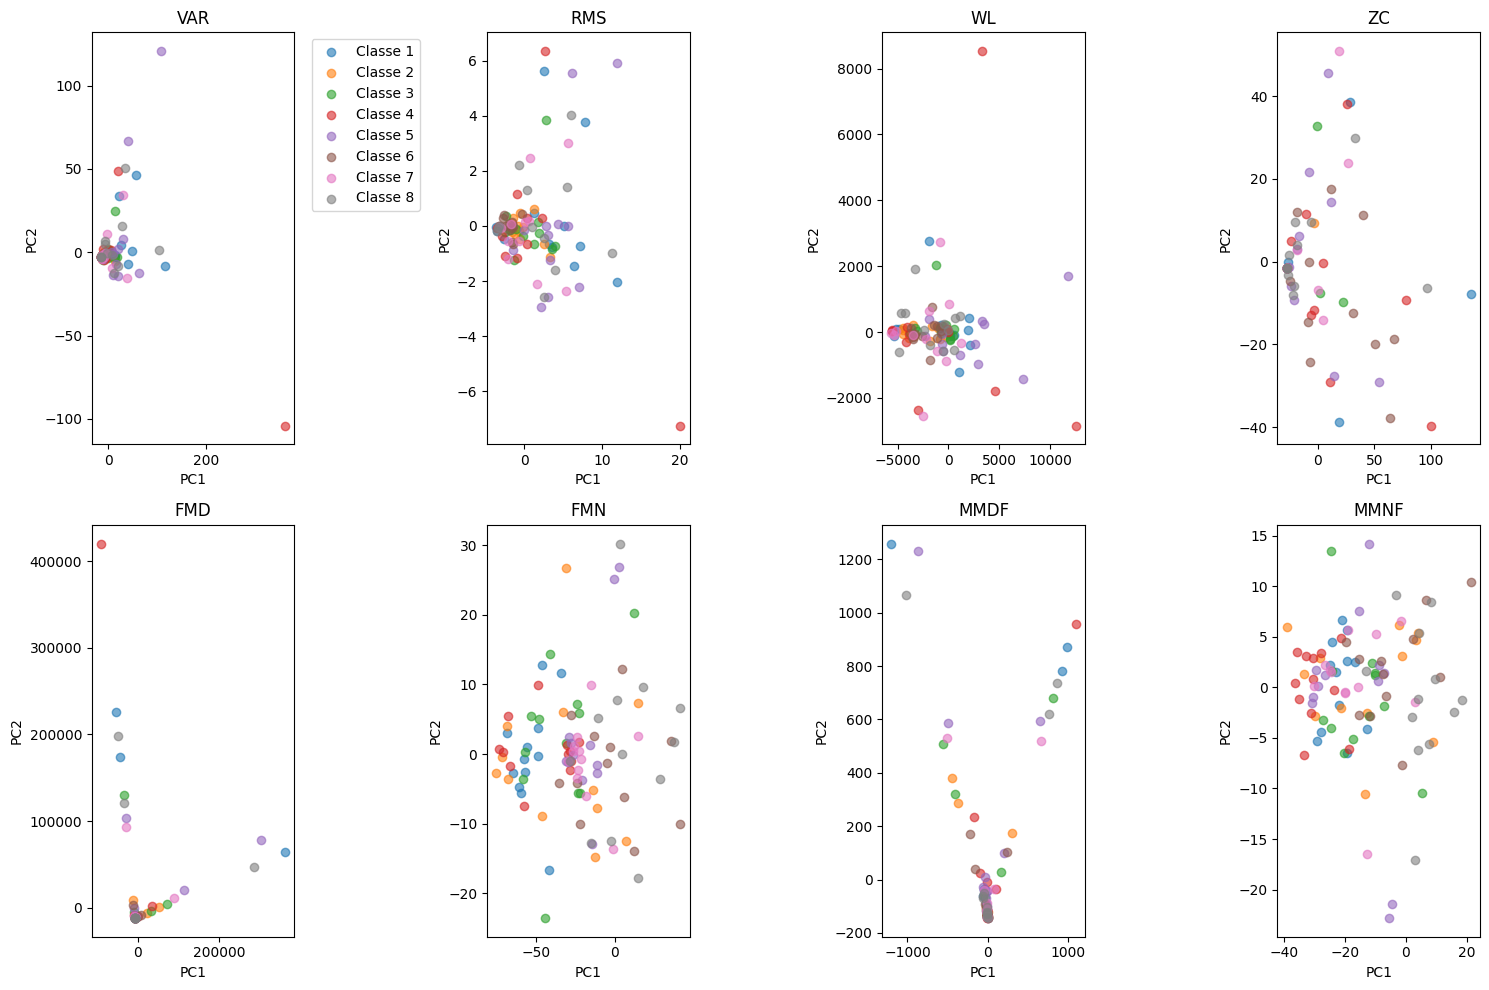

In [66]:
feature_names = ['VAR', 'RMS', 'WL', 'ZC', 'FMD', 'FMN', 'MMDF', 'MMNF']
pca = PCA(n_components=2)

plt.figure(figsize=(15, 10))
for i, name in enumerate(feature_names):
    plt.subplot(2, 4, i+1)
    
    feat_data = features[:, :, :, i].reshape(-1, 4)
    
    pca_result = pca.fit_transform(feat_data)
    
    for class_id in range(8):
        start = class_id * features.shape[1]
        end = start + features.shape[1]
        plt.scatter(pca_result[start:end, 0], pca_result[start:end, 1], 
                   label=f'Classe {class_id+1}', alpha=0.6)
    
    plt.title(name)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    if i == 0:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = SVC(kernel='rbf', gamma='scale')
clf.fit(X_train, y_train)

accuracy = clf.score(X_test, y_test)
print(f'Acurácia na base de teste: {accuracy:.2%}')

Acurácia na base de teste: 3.45%
